<a href="https://colab.research.google.com/github/BADS7604Group03/assignment3/blob/main/code/Project3_SequencialData_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import preprocessing

#Define Functions

In [ ]:
def split(x_array, y_array, ratio_train=0.8, ratio_test=0.1):
  n_data = x_array.shape[0]
  n_train = int(n_data * ratio_train)
  n_test = int(n_data *ratio_test)
  n_val = n_data -n_train -n_test
  x_train, y_train = x_array[:n_train], y_array[:n_train]
  x_val, y_val = x_array[n_train:n_train+n_val], y_array[n_train:n_train+n_val]
  x_test, y_test = x_array[n_train+n_val:], y_array[n_train+n_val:]
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
def window_return(val, window):
  lst_x = []
  lst_y = []
  lst_x_return = []
  lst_y_return = []
  for i in range(0,len(val) - window -1,1):
    first_price = val[i]
    lst_x.append(val[i:i+window])
    lst_y.append(val[i+window])
    lst_x_return.append((val[i+1:i+window]-first_price)/first_price)
    lst_y_return.append((val[i+window]-first_price)/first_price)
  array_x_return = np.array(lst_x_return).reshape(-1,window-1)
  array_y_return = np.array(lst_y_return).reshape(-1,1)
  array_x = np.array(lst_x).reshape(-1,window)
  array_y = np.array(lst_y).reshape(-1,1)
  return array_x,array_x_return,array_y,array_y_return

#Load Data

In [ ]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/BADS7604_Deep_Learning/Project3/BCH OHLC 10Y.xlsx"
df_trans = pd.read_excel(path,sheet_name='Daily').sort_values(by='Date', ascending=True)
df_trans.shape

(2469, 6)

In [ ]:
df_trans.tail(10)

,Date,Last Price,Open Price,High Price,Low Price,BCH TB Equity - Volume
9,2022-03-10,20.1,20.2,20.2,19.7,46136188
8,2022-03-11,20.5,20.0,20.6,20.0,24969364
7,2022-03-14,20.9,20.5,21.0,20.4,46296824
6,2022-03-15,21.0,21.0,21.2,20.8,35639216
5,2022-03-16,21.0,21.1,21.2,20.8,21344752
4,2022-03-17,21.0,20.9,21.3,20.9,21165356
3,2022-03-18,21.2,20.9,21.3,20.8,23403892
2,2022-03-21,21.8,21.4,21.9,21.3,31993000
1,2022-03-22,21.5,21.8,21.9,21.4,15422907
0,2022-03-23,21.3,21.5,21.8,21.3,13652618


In [ ]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 2468 to 0
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2469 non-null   datetime64[ns]
 1   Last Price              2469 non-null   float64       
 2   Open Price              2469 non-null   float64       
 3   High Price              2469 non-null   float64       
 4   Low Price               2469 non-null   float64       
 5   BCH TB Equity - Volume  2469 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 135.0 KB


In [ ]:
df_trans.describe(include='all',datetime_is_numeric=True)

,Date,Last Price,Open Price,High Price,Low Price,BCH TB Equity - Volume
count,2469,2469.000000,2469.000000,2469.000000,2469.000000,2.469000e+03
mean,2017-02-27 01:08:14.289185792,12.585439,12.593718,12.770543,12.416541,1.050543e+07
min,2012-02-09 00:00:00,5.360000,5.360000,5.440000,5.360000,1.911000e+05
25%,2014-08-20 00:00:00,7.900000,7.900000,8.080000,7.800000,3.712100e+06
50%,2017-02-28 00:00:00,13.100000,13.100000,13.300000,13.000000,7.320945e+06
75%,2019-09-06 00:00:00,16.100000,16.100000,16.300000,15.900000,1.296720e+07
max,2022-03-23 00:00:00,26.250000,26.500000,26.750000,25.750000,1.416106e+08
std,NaN,4.681297,4.688040,4.752978,4.615918,1.151587e+07


In [ ]:
window_size=20
x_close,x_return,y_close,y_return = window_return(df_trans["Last Price"].values, window_size)
print(f"x_close.shape : {x_close.shape}")
print(f"x_return.shape : {x_return.shape}")
print(f"v.shape : {y_close.shape}")
print(f"y_return.shape : {y_return.shape}")

x_close.shape : (2448, 20)
x_return.shape : (2448, 19)
v.shape : (2448, 1)
y_return.shape : (2448, 1)


In [ ]:
_, _, x_close_test, _, _, y_close_test = split(x_close, y_close, 0.8, 0.1)

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x_return, y_return, 0.8, 0.1)
print(len(x_train))
print(len(x_test))
print(len(x_val))

1958
244
246


In [ ]:
x_train.reshape(-1,1)

array([[ 0.00714286],
       [-0.00714286],
       [-0.02142857],
       ...,
       [-0.12179487],
       [-0.12820513],
       [-0.14102564]])

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train.reshape(-1,1))
X_train_norm = min_max_scaler.transform(x_train.reshape(-1,1)).reshape(x_train.shape)
Y_train_norm = min_max_scaler.transform(y_train.reshape(-1,1)).reshape(y_train.shape)
X_val_norm = min_max_scaler.transform(x_val.reshape(-1,1)).reshape(x_val.shape)
Y_val_norm = min_max_scaler.transform(y_val.reshape(-1,1)).reshape(y_val.shape)
X_test_norm = min_max_scaler.transform(x_test.reshape(-1,1)).reshape(x_test.shape)
Y_test_norm = min_max_scaler.transform(y_test.reshape(-1,1)).reshape(y_test.shape)

print(f"X_train_norm.shape : {X_train_norm.shape}")
print(f"Y_train_norm.shape : {Y_train_norm.shape}")
print(f"X_val_norm.shape : {X_val_norm.shape}")
print(f"Y_val_norm.shape : {Y_val_norm.shape}")
print(f"X_test_norm.shape : {X_test_norm.shape}")
print(f"Y_test_norm.shape : {Y_test_norm.shape}")

X_train_norm.shape : (1958, 19)
Y_train_norm.shape : (1958, 1)
X_val_norm.shape : (246, 19)
Y_val_norm.shape : (246, 1)
X_test_norm.shape : (244, 19)
Y_test_norm.shape : (244, 1)


In [ ]:
x_train_norm = X_train_norm.astype(np.float32)
y_train_norm = Y_train_norm.astype(np.float32)
x_val_norm = X_val_norm.astype(np.float32)
y_val_norm = Y_val_norm.astype(np.float32)
x_test_norm = X_test_norm.astype(np.float32)

In [ ]:
# len_t = len(x_train)
# len_v = len(x_val)

In [ ]:
# x_train_norm = np.array(x_train_norm)
# test_X = np.array(x_test)
# train_label = np.array(y_train)
# test_label = np.array(y_test)
# train_val = np.array(x_val)
# test_val = np.array(y_val)

In [ ]:
X_train_norm = X_train_norm.reshape(X_train_norm.shape[0],1,window_size-1,1)
X_val_norm = X_val_norm.reshape(X_val_norm.shape[0],1,window_size-1,1)
X_test_norm = x_test_norm.reshape(X_test_norm.shape[0],1,window_size-1,1)

In [ ]:
print(f"X_train_norm.shape : {X_train_norm.shape}")
print(f"Y_train_norm.shape : {Y_train_norm.shape}")
print(f"X_val_norm.shape : {X_val_norm.shape}")
print(f"Y_val_norm.shape : {Y_val_norm.shape}")
print(f"X_test_norm.shape : {X_test_norm.shape}")
print(f"Y_test_norm.shape : {Y_test_norm.shape}")

X_train_norm.shape : (1958, 1, 19, 1)
Y_train_norm.shape : (1958, 1)
X_val_norm.shape : (246, 1, 19, 1)
Y_val_norm.shape : (246, 1)
X_test_norm.shape : (244, 1, 19, 1)
Y_test_norm.shape : (244, 1)


#Run Model

In [ ]:
print(f"X_train_norm.shape : {X_train_norm.shape}")
print(f"Y_train_norm.shape : {Y_train_norm.shape}")
print(f"X_val_norm.shape : {X_val_norm.shape}")
print(f"Y_val_norm.shape : {Y_val_norm.shape}")
print(f"X_test_norm.shape : {X_test_norm.shape}")
print(f"Y_test_norm.shape : {Y_test_norm.shape}")

X_train_norm.shape : (1958, 1, 19, 1)
Y_train_norm.shape : (1958, 1)
X_val_norm.shape : (246, 1, 19, 1)
Y_val_norm.shape : (246, 1)
X_test_norm.shape : (244, 1, 19, 1)
Y_test_norm.shape : (244, 1)


In [ ]:
model = Sequential()
model.add(tf.keras.layers.InputLayer((1,19,1), name='Input'))
#add model layers
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='Nadam', loss='mse')
K.set_value(model.optimizer.learning_rate, 0.0001)

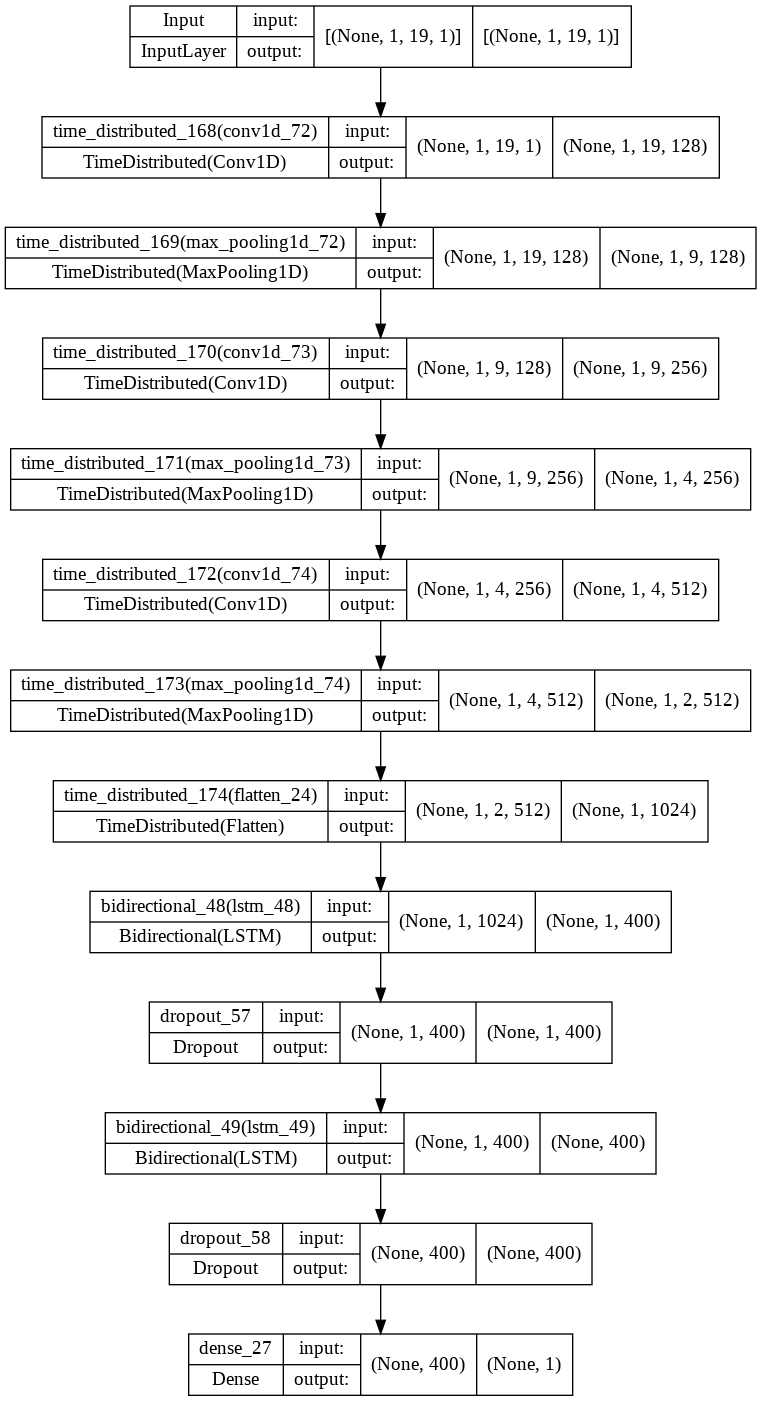

In [ ]:
tf.keras.utils.plot_model(model, 'Group_HW3_trainmodel.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

In [ ]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_168 (TimeD  (None, 1, 19, 128)       256       
 istributed)                                                     
                                                                 
 time_distributed_169 (TimeD  (None, 1, 9, 128)        0         
 istributed)                                                     
                                                                 
 time_distributed_170 (TimeD  (None, 1, 9, 256)        33024     
 istributed)                                                     
                                                                 
 time_distributed_171 (TimeD  (None, 1, 4, 256)        0         
 istributed)                                                     
                                                                 
 time_distributed_172 (TimeD  (None, 1, 4, 512)      

In [ ]:
model.fit(X_train_norm, Y_train_norm, validation_data=(X_val_norm,Y_val_norm), epochs=30,batch_size=64,shuffle =False)
print(model.evaluate(X_val_norm,Y_val_norm))

Epoch 1/30
31/31 [==============================] - 14s 171ms/step - loss: 0.1714 - val_loss: 0.0320
Epoch 2/30
31/31 [==============================] - 3s 110ms/step - loss: 0.0130 - val_loss: 0.0111
Epoch 3/30
31/31 [==============================] - 3s 111ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 4/30
31/31 [==============================] - 3s 111ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 5/30
31/31 [==============================] - 3s 111ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 6/30
31/31 [==============================] - 3s 111ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 7/30
31/31 [==============================] - 3s 111ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 8/30
31/31 [==============================] - 3s 110ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 9/30
31/31 [==============================] - 3s 109ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 10/30
31/31 [==============================] - 3s 110ms/step - loss: 0.0084 - val_loss: 0.009

In [ ]:
_, _, x_close_test, _, _, y_close_test = split(x_close, y_close, 0.8, 0.1)

In [ ]:
x_close_test.shape

(244, 20)

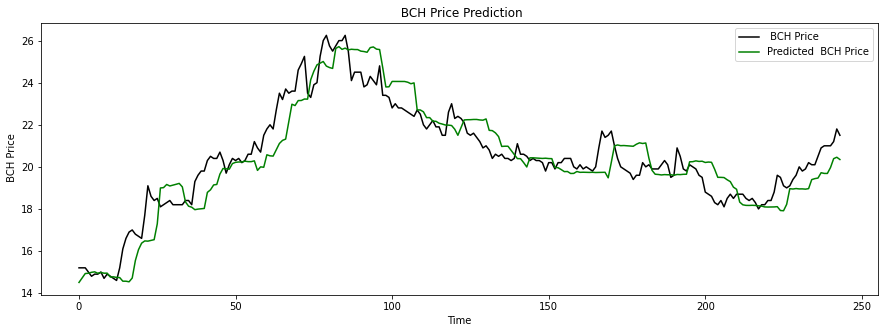

In [ ]:
predicted  = model.predict(X_test_norm)
predicted = min_max_scaler.inverse_transform(predicted)
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted_price = (x_close_test[:,0].reshape(-1,1)*(1+predicted)) # Return --> Price from P-20 x (1+return)
plt.figure(figsize=(15,5))
plt.plot(y_close_test, color = 'black', label = ' BCH Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted  BCH Price')
plt.title(' BCH Price Prediction')
plt.xlabel('Time')
plt.ylabel(' BCH Price')
plt.legend()
plt.show()

In [ ]:
#Normal case
mse = mean_squared_error(y_close_test,predicted_price)
mae = mean_absolute_error(y_close_test,predicted_price)



print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")

mean_squared_error : 0.9945332532120017
mean_absolute_error : 0.8040743936402877


In [ ]:
y = pd.DataFrame(predicted_price)
y

,0
0,14.505119
1,14.715599
2,14.929326
3,14.942621
4,14.986744
...,...
239,19.686302
240,19.967703
241,20.388341
242,20.456857


In [ ]:
y.to_excel (r'/content/drive/MyDrive/Colab Notebooks/BADS7604_Deep_Learning/Project3/return2.xlsx', index = False, header=True)